In order to write equation \eqref{eq:densidadEsFlujoSobreProductoRapidezPorAncho} as a function of
the aperture diameter of the bait bucket, we express the mass flow rate of bait as a function of the
aperture diameter, $\dot{m}(d)$. To do this, the bait in the bucket was weighed and the time
required to empty the bucket was measured and repeated using several aperture diameters. Figure
\ref{fig:flujoDeApertura} shows the results from the calibration as well as the fitted model.

## Calibration Demonstration

In [1]:
import nerd
import nerd.calibration
import nerd.density_functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import pandas as pd

## Fit flow rate

In [3]:
flow_data = pd.read_csv("/workdir/data/flow.csv")
flow_data = flow_data[flow_data.bait_status == "new"][["aperture", "flow"]]

In [4]:
aperture_diameters = flow_data.aperture.values
flow_rates = flow_data.flow.values
flow_rate_function = nerd.calibration.fit_flow_rate(aperture_diameters, flow_rates)

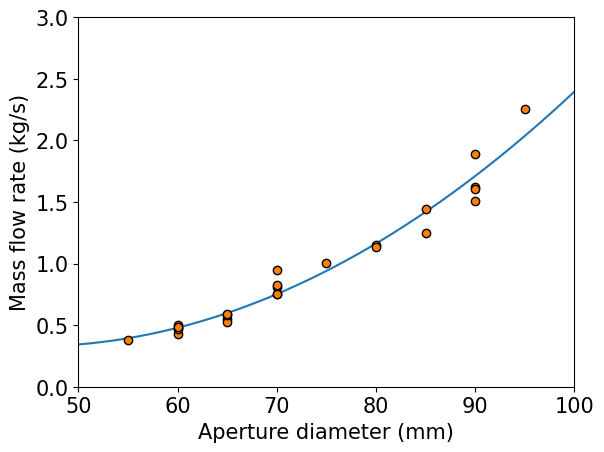

In [5]:
x = np.linspace(min(aperture_diameters) - 10, max(aperture_diameters) + 10)
y = flow_rate_function(x)
fontsize = 15


plt.plot(x, y)
plt.plot(aperture_diameters, flow_rates, "o", markeredgecolor="k")
plt.xlabel("Aperture diameter (mm)", size=fontsize)
plt.ylabel("Mass flow rate (kg/s)", size=fontsize)
plt.xlim(50, 100)
plt.ylim(0, 3)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
plt.savefig("calibration.png", dpi=300, transparent=True)

![Flow rate $\dot{m}$ (kg/s) as a function of aperture diameter, $d$ (mm); each symbol represents a
calibration event and the black curve is the quadratic model fitted to the data.]()

## Swath width

In [6]:
density_profile = pd.read_csv("/workdir/data/profile.csv")

In [7]:
distance = density_profile.distance.values
density_kg_per_ha = density_profile.density.values
density = density_kg_per_ha / 1e4  # To convert densities to kg per square meter
swath_width = nerd.calibration.get_swath_width(distance, density)

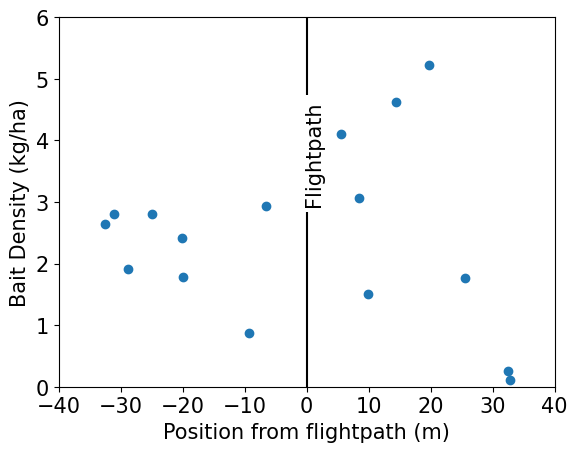

In [8]:
plt.plot(distance, density_kg_per_ha, "o")
plt.xlabel("Position from flightpath (m)", size=fontsize)
plt.ylabel("Bait Density (kg/ha)", size=fontsize)
plt.xlim(-40, 40)
plt.ylim(0, 6)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
plt.text(
    -0.5,
    3,
    "Flightpath",
    size=15,
    color="k",
    rotation=90,
    bbox=dict(facecolor="w", edgecolor="none"),
)
plt.axvline(0, color="k")
# plt.axvline(swath_width/2, color="k")
plt.savefig("plots.png", dpi=300, transparent=True)

## Select best density function

In [9]:
aperture_diameter_data = 55  # milimetres
helicopter_speed_data = 20.5778  # meters per second (40 knots)

In [10]:
density_function = nerd.calibration.get_best_density_function(
    distance,
    density,
    aperture_diameter_data,
    helicopter_speed_data,
    swath_width,
    flow_rate_function,
)
estimated_profile = nerd.solver(
    aperture_diameter_data,
    helicopter_speed_data,
    swath_width,
    density_function,
    flow_rate_function,
)

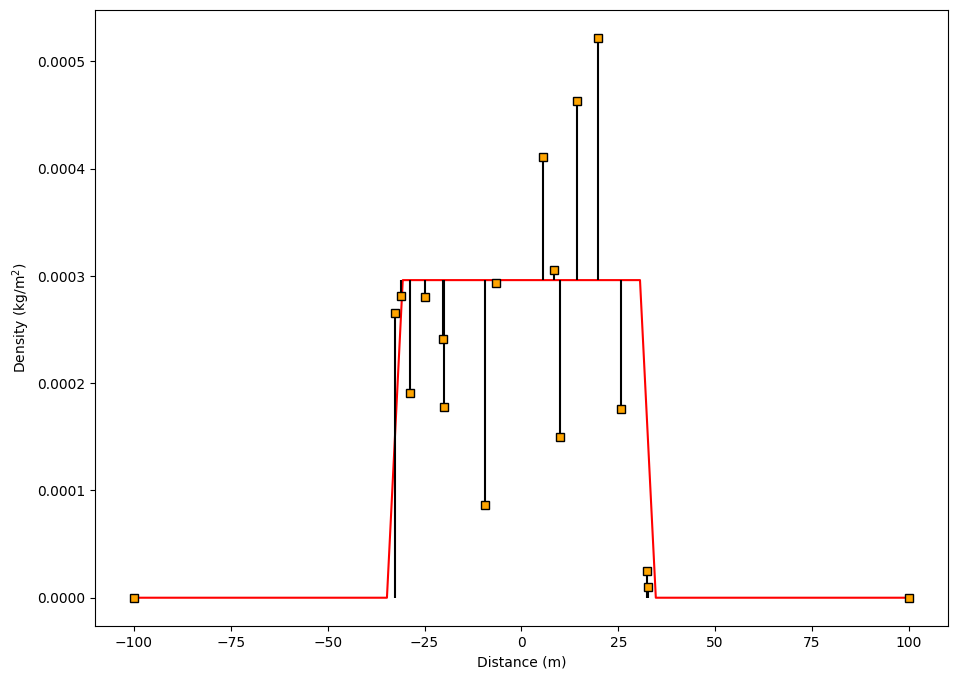

In [11]:
x = np.linspace(min(distance), max(distance))
y = estimated_profile(x)
estimated_density = estimated_profile(distance)
plt.figure(figsize=[11, 8])
plt.plot(x, y, "r", label="estimated density")
plt.vlines(distance, density, density + estimated_density - density, "k")
plt.plot(
    distance,
    density,
    "s",
    color="orange",
    markeredgecolor="black",
    label="real density",
)
plt.xlabel("Distance (m)")
plt.ylabel("Density (kg/m$^2$)");

## Calibration model

In [12]:
aperture_diameters_domain = np.linspace(min(aperture_diameters), max(aperture_diameters))
helicopter_speeds_domain = np.linspace(10, 50)
density_matrix = nerd.calibration.model(
    aperture_diameters_domain,
    helicopter_speeds_domain,
    swath_width,
    nerd.density_functions.uniform,
    flow_rate_function,
)
helicopter_speed_kmh = helicopter_speeds_domain * 3.6

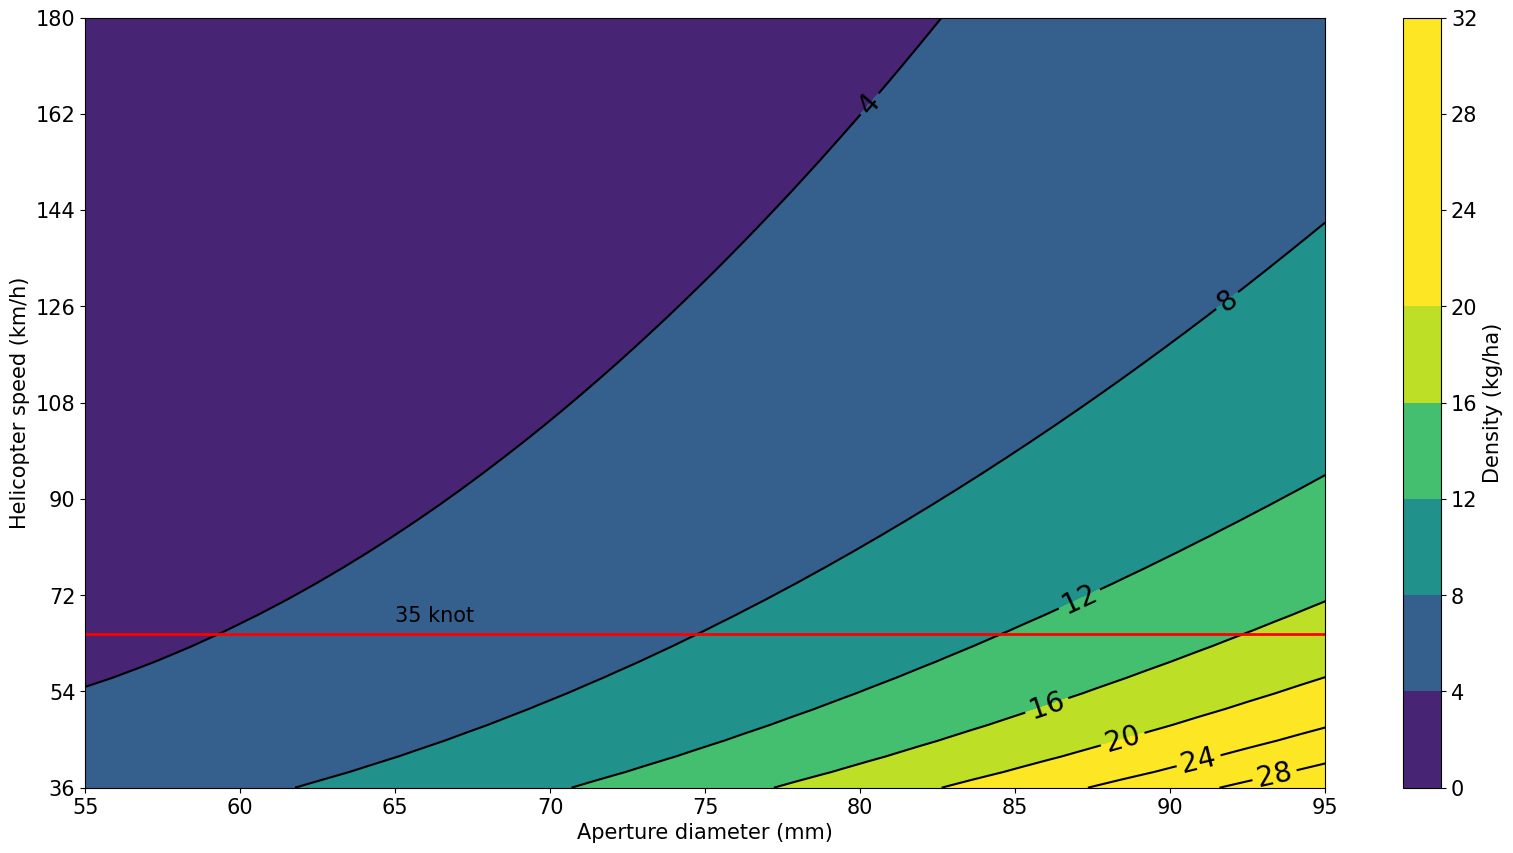

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
color_contour = ax.contourf(
    aperture_diameters_domain,
    helicopter_speeds_domain,
    density_matrix * 1e4,
    zorder=0,
    vmin=0,
    vmax=20,
)
line_contour = ax.contour(
    aperture_diameters_domain,
    helicopter_speeds_domain,
    density_matrix * 1e4,
    levels=color_contour.levels,
    colors="k",
)
cbar = fig.colorbar(color_contour)
ax.clabel(line_contour, line_contour.levels, inline=True, fontsize=20, fmt="%1.0f")
plt.xlabel("Aperture diameter (mm)", size=fontsize)
plt.ylabel("Helicopter speed (km/h)", size=fontsize)
# plt.ylim(40/3.6, 150/3.6)
ytickslocs = ax.get_yticks()
y_ticks_kmh = ytickslocs * 3.6
plt.yticks(ytickslocs, y_ticks_kmh.astype(int), size=fontsize)
plt.xticks(size=fontsize)
cbar.ax.set_ylabel("Density (kg/ha)", size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.axhline(18.0056, color="r", linewidth=2)
plt.text(65, 18.6, "35 knot", size=fontsize, color="k")
plt.savefig("contour_plot.png", dpi=300, transparent=True)

\ref{fig:densidadDeAperturaYRapidez} Surface bait density $\sigma$ (kg/ha) as a function of aperture
diameter $d$ (mm), and speed $s$ (km/hr). The horizontal axis shows the aperture diameter of the
bait bucket and the vertical axis shows the helicopter's speed. The resulting bait density on the
ground is shown in the second vertical color axis. $\sigma(d,s)= \frac{\dot{m}(d)}{s\cdot w}$.
\label{fig:densidadDeAperturaYRapidez}]()

The resulting three-dimensional model, $$\sigma(d,s)= \frac{\dot{m}(d)}{s\cdot w},$$ is shown in
Figure \ref{fig:densidadDeAperturaYRapidez}. During the planning stage of an eradication campaign,
this model can be used to determine the diameter of the bait bucket needed to achieve the desired
bait density on the ground, ensuring efficient bait coverage, while maximizing resources, time and
labor force.